In [5]:



get_features <- function(X, bp = c(0,22), wl = 2048, threshold = 5, parallel = 1)
{
  if(class(X) == "data.frame") {
  if(all(c("sound.files", "selec", "start", "end") %in% colnames(X))) 
  {
    start <- as.numeric(unlist(X$start))
    end <- as.numeric(unlist(X$end))
    sound.files <- as.character(unlist(X$sound.files))
    selec <- as.character(unlist(X$selec))
  }
  else stop(paste(paste(c("sound.files", "selec", "start", "end")[!(c("sound.files", "selec", "start", "end") %in% colnames(X))], collapse=", "), " Error in data frame"))
  }
  else  stop("Data Frame Error")
  
fs <- list.files(path = getwd(), pattern = ".wav$", ignore.case = TRUE)
  if(length(unique(sound.files[(sound.files %in% fs)])) != length(unique(sound.files))) 
    cat(paste(length(unique(sound.files))-length(unique(sound.files[(sound.files %in% fs)])), 
              ".wav file(s) not found"))
  
  d <- which(sound.files %in% fs) 
  if(length(d) == 0){
    stop("wav file not found in dir.")
  }  else {
    start <- start[d]
    end <- end[d]
    selec <- selec[d]
    sound.files <- sound.files[d]
  }
  
      # If parallel is not numeric
  if(!is.numeric(parallel)) stop("'parallel' must be a numeric vector of length 1") 
  if(any(!(parallel %% 1 == 0),parallel < 1)) stop("'parallel' should be a positive integer")
  
  # If parallel was called
  if(parallel > 1)
  { options(warn = -1)
    if(all(Sys.info()[1] == "Windows",requireNamespace("parallelsugar", quietly = TRUE) == TRUE)) 
      lapp <- function(X, FUN) parallelsugar::mclapply(X, FUN, mc.cores = parallel) else
        if(Sys.info()[1] == "Windows"){ 
          cat("Windows users need to install the 'parallelsugar' package for parallel computing (you are not doing it now!)")
          lapp <- pbapply::pblapply} else lapp <- function(X, FUN) parallel::mclapply(X, FUN, mc.cores = parallel)} else lapp <- pbapply::pblapply
  
  options(warn = 0)
 
  if(parallel == 1) cat("Getting params")
  
  x <- as.data.frame(lapp(1:length(start), function(i) { 
  
    r <- tuneR::readWave(file.path(getwd(), sound.files[i]), from = start[i], to = end[i], units = "seconds") 
    
    b<- bp 
    
    if(b[2] > ceiling(r@samp.rate/2000) - 1)
                    b[2] <- ceiling(r@samp.rate/2000) - 1 
    
    
    #get  freq spectrum 
    
    songspec <- seewave::spec(r, f = r@samp.rate, plot = TRUE)
    analysis <- seewave::specprop(songspec, f = r@samp.rate, flim = c(0, 280/1000), plot = TRUE)
    
    
    # the required papameters (meanfreq, median, Q25, etc. They are all returns of the function specprop)
    
    meanfreq <- analysis$mean/1000
    sd <- analysis$sd/1000
    median <- analysis$median/1000
    Q25 <- analysis$Q25/1000
    Q75 <- analysis$Q75/1000
    IQR <- analysis$IQR/1000
    skew <- analysis$skewness
    kurt <- analysis$kurtosis
    sp.ent <- analysis$sh
    sfm <- analysis$sfm
    mode <- analysis$mode/1000
    centroid <- analysis$cent/1000
    


    peakf <- 0
    
    # Get Fundamental frequency 
    ff <- seewave::fund(r, f = r@samp.rate, ovlp = 50, threshold = threshold, fmax = 280, ylim=c(0, 280/1000), plot = FALSE, wl = wl)[, 2]
   
    meanfun<-mean(ff, na.rm = T)
    minfun<-min(ff, na.rm = T)
    maxfun<-max(ff, na.rm = T)
    
    #Get Dominant frecuency 
    y <- seewave::dfreq(r, f = r@samp.rate, wl = wl, ylim=c(0, 280/1000), ovlp = 0, plot = F, threshold = threshold, bandpass = b * 1000, fftw = TRUE)[, 2]
    
    meandom <- mean(y, na.rm = TRUE)
    mindom <- min(y, na.rm = TRUE)
    maxdom <- max(y, na.rm = TRUE)
    dfrange <- (maxdom - mindom)
    duration <- (end[i] - start[i])
    
    #get modulation index 
    changes <- vector()
    for(j in which(!is.na(y))){
      change <- abs(y[j] - y[j + 1])
      changes <- append(changes, change)
    }
    if(mindom==maxdom) modindx<-0 else modindx <- mean(changes, na.rm = T)/dfrange
    
    
    # save all features
    return(c(duration, meanfreq, sd, median, Q25, Q75, IQR, skew, kurt, sp.ent, sfm, mode, 
             centroid, peakf, meanfun, minfun, maxfun, meandom, mindom, maxdom, dfrange, modindx))
  }))
  
  # Rename columns to be similar to the features in the dataset used for training.
  
  rownames(x) <- c("duration", "meanfreq", "sd", "median", "Q25", "Q75", "IQR", "skew", "kurt", "sp.ent", 
                   "sfm","mode", "centroid", "peakf", "meanfun", "minfun", "maxfun", "meandom", "mindom", "maxdom", "dfrange", "modindx")
  x <- data.frame(sound.files, selec, as.data.frame(t(x)))
  
  colnames(x)[1:2] <- c("sound.files", "selec")
  rownames(x) <- c(1:nrow(x))
  
  return(x)
}

#the code is inspired from a similar code @ https://github.com/PrathamSolanki/gender-recognition-by-voice/tree/master/Application



Getting params

Warning message in (0:(n - 1)) * f:
"NAs produced by integer overflow"

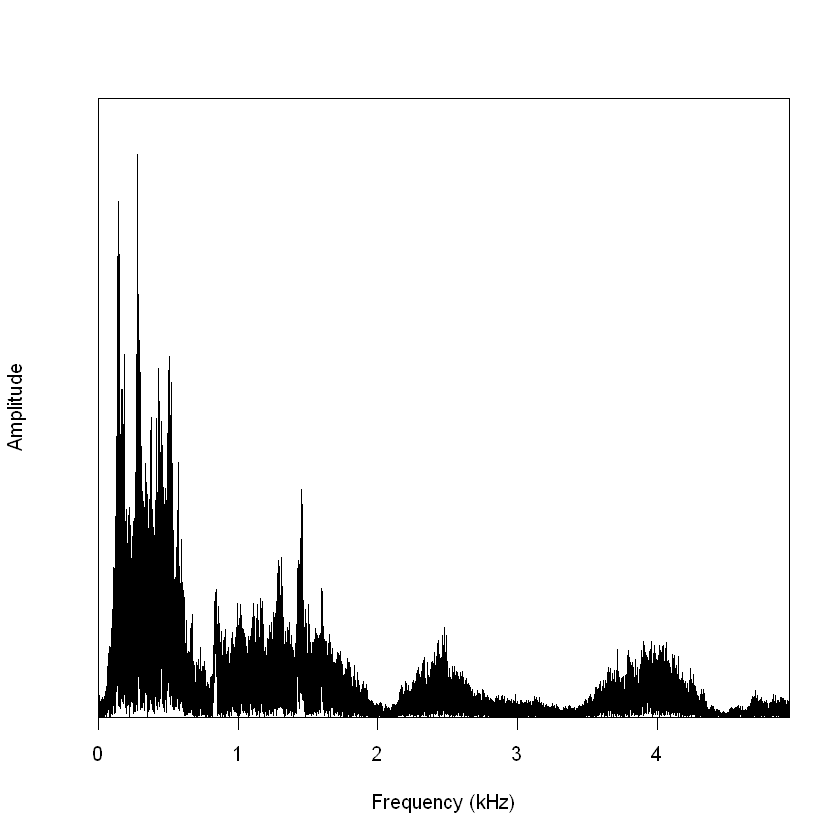

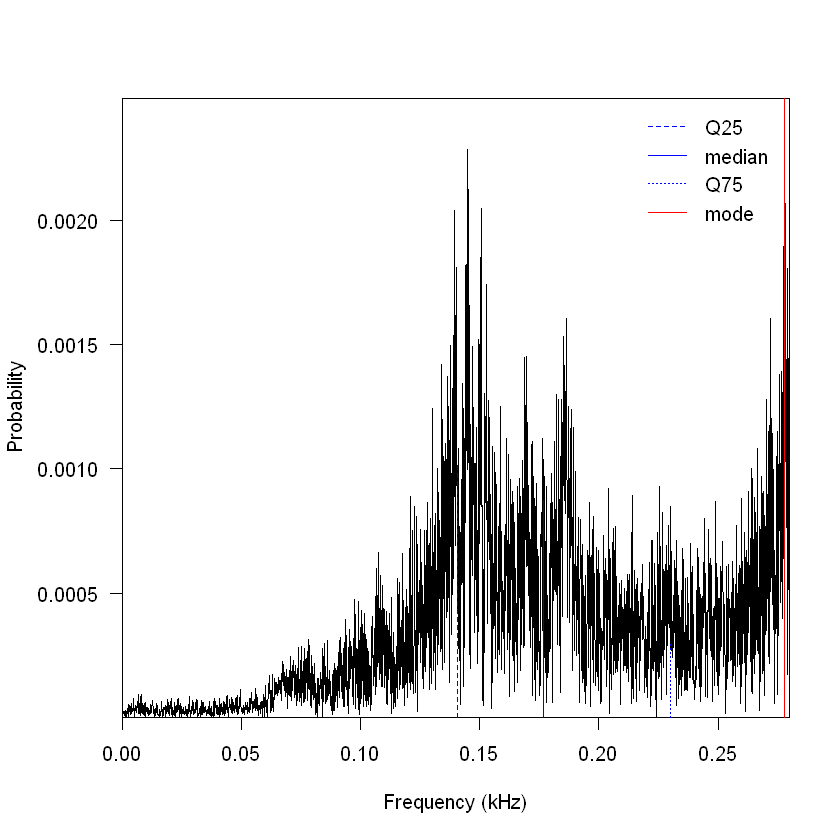

In [6]:

# main
data = data.frame("brian.wav", 0, 0, 20) # file name
names(data) <- c('sound.files', 'selec', 'start', 'end')

acoustics <- get_features(data)

write.csv(acoustics, file = "brian.csv")